In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import muon as mu
import deconvatac as decon
import os
import scanpy as sc

In [28]:
# Load Heart data
mdata = mu.read("/vol/storage/data/cellxgene/human_cardiac_niches/human_cardiac_niches.h5mu")

In [ ]:
mdata

MuData object with n_obs × n_vars = 139835 × 462560
  var:	'highly_variable'
  2 modalities
    atac:	139835 x 429828
      obs:	'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'batch_key', 'cell_type', 'cell_state'
      var:	'highly_variable'
      layers:	'tfidf_normalized'
    rna:	139835 x 32732
      obs:	'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
      var:	'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_type_colors', 'facility_colors', 'flushed_colors', 'gender_colors', 'hvg', 'kit_10x_colors', 'leiden', 'log1p', 'modality_colors', 'neighbors', 'original_or_new_colors', 'region_colors', 'region_finest_colors', 'scANVI_predictions_colors', 'umap'
      obsm:	'X_scArches', 'X_umap'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

In [ ]:
# Create parameter dictionary
params = {
    "Heart_1": {
        "n_regions": 1,
        "cell_type_number": [3],
        "cell_number_nu": [20],
        "cell_number_mean": [5],
        "region_type": "stripes",
        "num_spots": 1000,
        "balance": "balanced",
    },
    "Heart_2": {
        "n_regions": 1,
        "cell_type_number": [10],
        "cell_number_nu": [20],
        "cell_number_mean": [15],
        "region_type": "stripes",
        "num_spots": 1000,
        "balance": "balanced",
    },
    "Heart_3": {
        "n_regions": 4,
        "cell_type_number": [10, 5, 10, 5],
        "cell_number_nu": [20, 20, 20, 20],
        "cell_number_mean": [15, 10, 15, 5],
        "region_type": "stripes",
        "num_spots": 1000,
        "balance": "balanced",
    },
    "Heart_4": {
        "n_regions": 4,
        "cell_type_number": [3, 5, 3, 5],
        "cell_number_nu": [20, 20, 20, 20],
        "cell_number_mean": [15, 10, 15, 5],
        "region_type": "circles",
        "num_spots": 1000,
        "balance": "balanced",
    },
}


In [58]:
for key, param in params.items():
    if os.path.exists(os.path.join("/vol/storage/data/simulations", f"{key}.h5mu")):
        continue
    print(key)
    print(param)
    test = decon.tl.generate_spatial_data(mdata, cell_type_key="cell_type", **param)

    test_atac = process_spatial(test, 'atac')
    test_rna = process_spatial(test, "rna")
    test = mu.MuData({'atac': test_atac, 'rna': test_rna})
    test.write(os.path.join("/vol/storage/data/simulations", f"{key}.h5mu"))

Heart_4
{'n_regions': 4, 'cell_type_number': [3, 5, 3, 5], 'cell_number_nu': [20, 20, 20, 20], 'cell_number_mean': [15, 10, 15, 5], 'region_type': 'circles', 'num_spots': 1000, 'balance': 'balanced'}
Region 0: ['Mast cell' 'Mural cell' 'Mesothelial cell'] (mean cells per cluster: 14.577777777777778)
Region 1: ['Mast cell' 'Lymphoid' 'Mesothelial cell' 'Neural cell'
 'Ventricular Cardiomyocyte'] (mean cells per cluster: 9.469696969696969)
Region 2: ['Lymphatic Endothelial cell' 'Myeloid' 'Mast cell'] (mean cells per cluster: 14.535714285714286)
Region 3: ['Mast cell' 'Ventricular Cardiomyocyte' 'Adipocyte'
 'Atrial Cardiomyocyte' 'Myeloid'] (mean cells per cluster: 4.4714285714285715)


In [45]:
import matplotlib.pyplot as plt

import pandas as pd
# Now we will create a function to plot pie charts at specified coordinates
def plot_pie_charts(spots_data, x_coords, y_coords):
    # Assuming we have equal numbers of spots and coordinates
    assert len(spots_data) == len(x_coords) == len(y_coords)

    fig, ax = plt.subplots()

    # Size of the entire plotting area
    ax.set_xlim(min(x_coords) - 4, max(x_coords) + 4)
    ax.set_ylim(min(y_coords) - 4, max(y_coords) + 4)

    # Creating a pie chart for each spot
    for data, x, y in zip(spots_data, x_coords, y_coords):
        # sizes = list(data.values())
        # labels = list(data.keys())
        ax.pie(data, labels=None, radius=4, center=(x, y), colors=mdata["rna"].uns["cell_type_colors"])

    return ax

## Visualize the data

In [5]:
import pandas as pd
import scanpy as sc

In [59]:
test = mu.read("/vol/storage/data/simulations/Heart_4.h5mu")

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [60]:
test["atac"].obs = test["atac"].obs.reset_index().join(
    pd.DataFrame(test["atac"].obsm["proportions"], columns=test["atac"].uns["proportion_names"]).reset_index(drop=True))

In [61]:
test['atac'].obs['most_abundant'] = test["atac"].obs.iloc[:, 2:].idxmax(axis=1)

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


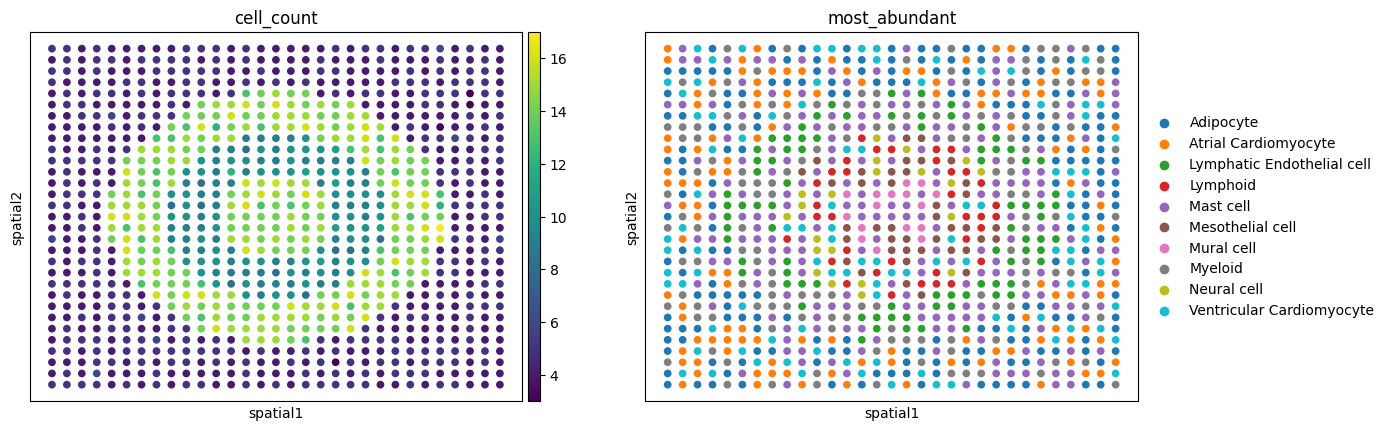

In [62]:
sc.pl.embedding(
    test["atac"],
    basis="spatial",
    color=['cell_count', 'most_abundant'],
)

In [3]:
test = mu.read("/vol/storage/data/simulations/Heart_3.h5mu")

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
def process_spatial(mudata, layer):
    if layer == "rna":
        adata = mudata.mod["rna"]
        # pca
        adata.layers['counts'] = adata.X.copy()
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
        sc.pp.pca(adata)
        sc.pp.neighbors(adata, use_rep="X_pca")
        sc.tl.leiden(adata, key_added="leiden_pca")

        adata.layers['log_norm'] = adata.X.copy()
        adata.X = adata.layers["counts"].copy()

        adata.layers.pop("counts")
    elif layer == "atac":
        adata = mudata.mod["atac"]
        adata.layers['counts'] = adata.X.copy()

        # PCA
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)

        adata.layers['log_norm'] = adata.X.copy()
        sc.pp.pca(adata)
        sc.pp.neighbors(adata, use_rep="X_pca")
        sc.tl.leiden(adata, key_added="leiden_pca")

        # TF-IDF
        adata.X = adata.layers["counts"].copy()
        mu.atac.pp.tfidf(adata)
        mu.atac.tl.lsi(adata)

        sc.pp.neighbors(adata, use_rep="X_lsi")
        sc.tl.leiden(adata, key_added="leiden_lsi")

        adata.layers['tfidf_normalized'] = adata.X.copy()
        adata.X = adata.layers["counts"].copy()

        adata.layers.pop("counts")
    return adata


In [23]:
lala = process_spatial(test, "rna")

In [16]:
lala.layers['tfidf_normalized'].max()


6.418750763177449

In [25]:
lala.X.max()

4.382421791348707